<a href="https://colab.research.google.com/github/shMotaharpour/Machine-learning-Practices/blob/MAPSA-ML/hosein_k_armed_bandit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports Libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

# Definitions

In [2]:
from abc import ABC, abstractmethod
class KBandit:

  def __init__(self, k, *, iteration = 500):
    self.k = k
    self.iteration = iteration    
    self.mean_reward = 0 
    self.mean_action_reward = np.zeros(k)
    self.number_action_selection = np.zeros(k)
    self.qa = np.random.normal(0, 1, k)
    self.round = 0
    self.iteration_reward = np.zeros(iteration)
    self.last_action = None

  @abstractmethod  
  def select_action(self):
      ...

  def do_action(self):
    self.last_action = self.select_action()
    action = self.last_action
    reward = np.random.normal(self.qa[action], 1)
    self.round += 1
    self.mean_reward= self.mean_reward + (reward - self.mean_reward)/self.round
    self.number_action_selection[action] += 1
    self.mean_action_reward[action] = self.mean_action_reward[action] + (reward - self.mean_action_reward[action])/self.number_action_selection[action]

  def run_iteration(self):
    for i in range(self.iteration):
      self.do_action()
      self.iteration_reward[i] = self.mean_reward

## **𝛆** - Greedy

In [3]:
class KBanditEpsilonGreedy(KBandit):
    
  def __init__(self, k, epsilon, *, iteration = 500):
    super().__init__(k, iteration=iteration)
    self.epsilon = epsilon
      
  def select_action(self):
    selection_index = np.random.rand()
    if self.round == 0:
        action = np.random.choice(self.k) 
    elif self.epsilon > selection_index:   # exploration
        action = np.random.choice(self.k)
    else:   # exploit
        action = np.argmax(self.mean_action_reward)
    return action

## upper confidence bound (UCB)

In [4]:
class KBanditUCB(KBandit):
    
  def __init__(self, k, c, *, iteration = 500, over_time = False):
    super().__init__(k, iteration=iteration)
    self.c = c
    self.delta = np.ones(k) * np.inf
    self.over_time = over_time
    if self.over_time:
      self.over_time_delta = np.ones((iteration + 1, k)) * np.inf
      self.over_time_action_reward = np.zeros((iteration + 1, k))
        
  def select_action(self):
    return np.argmax(self.mean_action_reward + self.delta)

  def do_action(self):
    super().do_action()
    new_delta_a = self.c * np.sqrt(np.log(self.round + 1) / self.number_action_selection[self.last_action])
    self.delta[self.last_action] = new_delta_a
    if self.over_time:
      self.over_time_action_reward[self.round, :] = self.mean_action_reward
      self.over_time_delta[self.round, :] = self.delta

## Automatic manufacturing and testing process

In [5]:
def auto_models_maker(k:int, eps:list, ucb_c:list, *, iteration = 500, episodes = 100):
  eps_rewards = [np.zeros(iteration) for _ in range(len(eps))]
  ucb_rewards = [np.zeros(iteration) for _ in range(len(ucb_c))]
  for i in range(episodes):
    eps_objs = [KBanditEpsilonGreedy(k, e, iteration=iteration) for e in eps]
    ucb_objs = [KBanditUCB(k, c, iteration=iteration) for c in ucb_c]
    for objs, rewards in zip([eps_objs, ucb_objs], [eps_rewards, ucb_rewards]):
      for agent, reward in zip(objs, rewards):
        agent.run_iteration()
        reward += (agent.iteration_reward - reward) / (i+1)
  return eps_rewards, ucb_rewards

In [6]:
def auto_ploter(eps:list, eps_rewards:list, ucb_c:list, ucb_rewards:list):
  fig, axes = plt.subplots(1, 3, figsize=(23,8))
  eps_max_dic = {}
  ucb_max_dic = {}
  for num, reward in zip(eps, eps_rewards):
    name = "e=" + str(num)
    axes[0].plot(reward, label =name)
    eps_max_dic[name] = reward.max()
  for num, reward in zip(ucb_c, ucb_rewards):
    name = "c=" + str(num)
    axes[1].plot(reward, label = name)
    ucb_max_dic[name] = reward.max()
  for ax in axes[:-1]:
    ax.legend()
  axes[0].set_ylabel('rewards per act number')
  min_lvl = round(min(min(eps_max_dic.values()), min(ucb_max_dic.values())) * 0.98, 2)
  axes[2].bar(eps_max_dic.keys(), eps_max_dic.values(), label='eps')
  axes[2].bar(ucb_max_dic.keys(), ucb_max_dic.values(), label='UCB')
  axes[2].set_ylim(min_lvl)
  axes[2].set_ylabel('max reward per parameters')
  axes[2].tick_params(axis='x', labelrotation=45)
  emax = max(eps_max_dic, key=eps_max_dic.get)
  cmax = max(ucb_max_dic, key=ucb_max_dic.get)
  print('Max reward:\n\t for eps-greedy is {} for {}\n\t for UCB is {} for {}'.format(eps_max_dic[emax], emax, ucb_max_dic[cmax], cmax))

# Comparison

In [7]:
e_list = [0, 0.001, 0.01, 0.03, 0.1, 0.3, 0.5, 0.7]
c_list = [0, 0.001, 0.01, 0.03, 0.1, 0.3, 0.5, 0.7, 1, 2, 5, 10]

In [8]:
eps_rewards, ucb_rewards = auto_models_maker(5, e_list,c_list, iteration=2000, episodes=100)

Max reward:
	 for eps-greedy is 1.142351049354528 for e=0.03
	 for UCB is 1.1065500131704413 for c=2


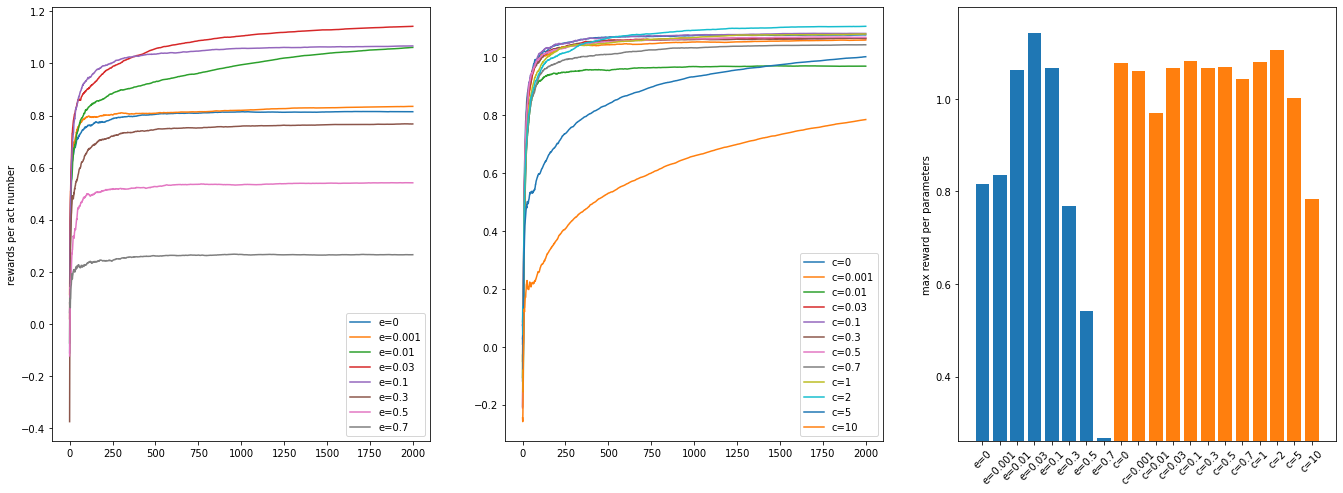

In [9]:
auto_ploter(e_list, eps_rewards, c_list, ucb_rewards)

# UCB Over time

In [10]:
k_band = 4
c_ubc = 0.01
model = KBanditUCB(k=k_band, c=c_ubc, iteration=500, over_time=True)
model.run_iteration()

## Make Video

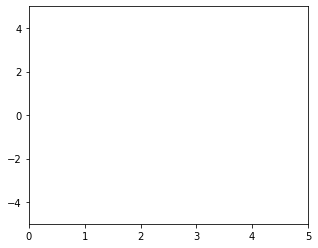

In [11]:
x_s = range(1, 1 + k_band)
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(autoscale_on=False, xlim=(0, k_band + 1), ylim=(-5, 5))
time_template = 'Action = %.0f'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
# ax.set_autoscaley_on(True)
# ax.grid()
line_mid, = ax.plot([], [], markersize=50, ls='None', marker='_', color='b')
line_up, = ax.plot([], [], markersize=20, ls='None', marker='_', color='r')
line_down, = ax.plot([], [], markersize=20, ls='None', marker='_', color='r')

def animate(i):
  line_mid.set_data(x_s, model.over_time_action_reward[i,:])
  line_up.set_data(x_s, model.over_time_action_reward[i,:] + model.over_time_delta[i,:])
  line_down.set_data(x_s, model.over_time_action_reward[i,:] - model.over_time_delta[i,:])
  time_text.set_text(time_template % (i))
  return line_mid, line_up, line_down, time_text,

In [12]:
ani = animation.FuncAnimation(
fig, animate, model.iteration, interval=100, blit=True)
file_name = f'{k_band}-armed-bandit by UCB with c={c_ubc}_animation.mp4'
ani.save(file_name, fps=10, extra_args=['-vcodec', 'libx264'])
print(f'Animation Saved as {file_name}.\nDownload and play')

Animation Saved as 4-armed-bandit by UCB with c=0.01_animation.mp4.
Download and play
